In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd

import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.2)

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.display import display

In [2]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [3]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser, host='/var/run/postgresql')
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [4]:
query = """
SELECT * FROM echo_filtered_MICU
"""
ef = pd.read_sql_query(query, con)
ef.head()

,row_id,icustay_id,hadm_id,subject_id,age_at_intime,gender,height,weight,bmi,ethnicity,...,fl_day1_output_ml,fl_day1_balance_ml,fl_day2_input_ml,fl_day2_output_ml,fl_day2_balance_ml,fl_day3_input_ml,fl_day3_output_ml,fl_day3_balance_ml,most_recent_hadm,first_echo
0,60492,294980,161160,105,12897 days 16:59:55,F,60.0,88.0,17.184444,BLACK/AFRICAN AMERICAN,...,310.0,4740.000000,1900.000000,546.0,1354.000000,130.000000,524.0,-394.000000,1,1
1,82787,252051,145167,106,10348 days 18:35:44,M,72.0,152.0,20.612654,UNKNOWN/NOT SPECIFIED,...,2010.0,-1564.012497,973.779999,2520.0,-1546.220001,500.000000,3400.0,-2900.000000,1,1
2,70124,249202,155897,111,25166 days 04:13:59,F,67.0,118.0,18.479394,WHITE,...,20.0,5742.809568,NaN,NaN,NaN,NaN,NaN,NaN,1,1
3,77777,218740,182743,164,30172 days 15:34:05,M,71.0,154.0,21.476294,WHITE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
4,105319,252789,176764,175,-103922 days +21:47:45.290448,M,NaN,NaN,NaN,WHITE,...,2535.0,-248.250000,1019.500004,1485.0,-465.499996,860.931246,1170.0,-309.068754,1,1


In [5]:
ef.columns.tolist()

['row_id',
 'icustay_id',
 'hadm_id',
 'subject_id',
 'age_at_intime',
 'gender',
 'height',
 'weight',
 'bmi',
 'ethnicity',
 'insurance',
 'ex_congestive_heart_failure',
 'ex_cardiac_aarrhythmias',
 'ex_valvular_disease',
 'ex_pulmonary_circulation',
 'ex_peripheral_vascular',
 'ex_hypertension',
 'ex_paralysis',
 'ex_other_neurological',
 'ex_chronic_pulmonary',
 'ex_diabetes_uncomplicated',
 'ex_diabetes_complicated',
 'ex_hypothyroidism',
 'ex_renal_failure',
 'ex_liver_disease',
 'ex_peptic_ulcer',
 'ex_aids',
 'ex_lymphoma',
 'ex_metastatic_cancer',
 'ex_solid_tumor',
 'ex_rheumatoid_arthritis',
 'ex_coagulopathy',
 'ex_obesity',
 'ex_weight_loss',
 'ex_fluid_electrolyte',
 'ex_blood_loss_anemia',
 'ex_deficiency_anemias',
 'ex_alcohol_abuse',
 'ex_drug_abuse',
 'ex_psychoses',
 'ex_depression',
 'apsiii',
 'apsiii_prob',
 'apsiii_creatinine_score',
 'admittime',
 'dischtime',
 'intime',
 'outtime',
 'dod',
 'survived_icustay',
 'survived_hadm',
 'ed_chartdate',
 'ed_charttime',

In [6]:
len(ef)

1226

-4.0 2972.0
52
366
count     821.000000
mean      211.271620
std       483.598726
min        -4.000000
25%         0.000000
50%         0.000000
75%       128.000000
max      2972.000000
dtype: float64


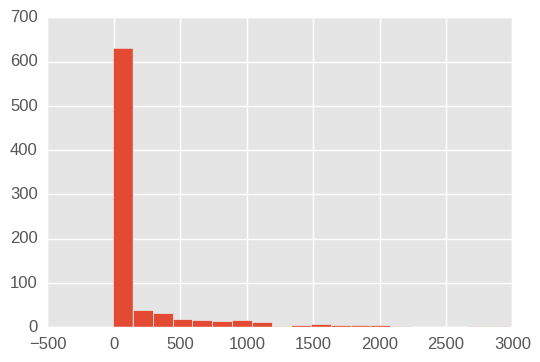

In [7]:
plot_data = ef.ea_days_after_discharge_death.values
plot_data = plot_data[~np.isnan(plot_data)]
plt.hist(plot_data, bins=20)
print(plot_data.min(), plot_data.max())
print(np.sum(plot_data < 0)) # only 324 out of 10k died before discharge???
print(np.sum(plot_data == 0)) # 2512 died at 0 minutes after discharge???
print(pd.Series(plot_data).describe())

In [8]:
day30_mortality = ef.ea_days_after_discharge_death <= 30

In [9]:
day30_mortality.value_counts()

False    700
True     526
Name: ea_days_after_discharge_death, dtype: int64

In [10]:
ef['day30_mortality'] = day30_mortality

In [11]:
ef.groupby(['day30_mortality', 'mech_vent']).size().unstack()

mech_vent,0,1
day30_mortality,,
False,343,357
True,201,325


In [12]:
ef.groupby(['day30_mortality', 'noninv_vent']).size().unstack()

noninv_vent,0,1
day30_mortality,,
False,149,551
True,71,455


In [13]:
%%bash
cat ../resources/lv_systolic.txt

====-1
Hyperdynamic LVEF >75%
Hyperdynamic LVEF
Left ventricular systolic function is hyperdynamic (EF>75%)
Hyperdynamic left ventricular systolic function
Hyperdynamic LVEF (>75%)
====0
Overall normal LVEF (>55%)
Normal LV wall thickness, cavity size and regional/global systolic function (LVEF >55%)
Low normal LVEF
Normal LV wall thickness, cavity size, and systolic function (LVEF>55%)
Mild symmetric LVH with normal cavity size and regional/global systolic function (LVEF>55%)
Overall left ventricular systolic function is normal (LVEF>55%)
Normal LV wall thickness, cavity size, and global systolic function (LVEF>55%)
Left ventricular wall thickness, cavity size, and systolic function are normal (LVEF>55%)
Mild symmetric LVH with normal cavity size and systolic function (LVEF>55%)
Mild symmetric LVH with normal cavity size and global systolic function (LVEF>55%)
Overall left ventricular systolic function is low normal (LVEF 50-55%)
There is mild symmetric left ventricular hypertrophy wi

In [14]:
table = ef.groupby(['day30_mortality', 'ea_lv_systolic']).size().unstack()
table

ea_lv_systolic,-50.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,
False,4,52,378,56,32,58
True,1,62,243,35,30,82


In [15]:
table = ef.groupby(['day30_mortality', 'ea_lv_systolic']).size().unstack()
table /= table.sum(axis=0)
table ## severely depressed and hyperdynamic have increased likelihood of death

ea_lv_systolic,-50.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,
False,0.8,0.45614,0.608696,0.615385,0.516129,0.414286
True,0.2,0.54386,0.391304,0.384615,0.483871,0.585714


In [16]:
table = ef.groupby(['day30_mortality', 'ex_congestive_heart_failure']).size().unstack()
table

ex_congestive_heart_failure,0,1
day30_mortality,,
False,427,273
True,296,230


In [17]:
table = ef.groupby(['day30_mortality', 'ex_congestive_heart_failure']).size().unstack()
table /= table.sum(axis=0)
table

ex_congestive_heart_failure,0,1
day30_mortality,,
False,0.590595,0.542744
True,0.409405,0.457256


In [18]:
for name,group in ef.groupby('ex_congestive_heart_failure'):
    table = group.groupby(['day30_mortality', 'ea_lv_systolic']).size().unstack()
    #table /= table.sum(axis=0)
    print('Congestive heart failure =', name)
    display(table)

Congestive heart failure = 0


ea_lv_systolic,-50.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,
False,4,38,258,30,10,23
True,1,47,158,21,7,26


Congestive heart failure = 1


ea_lv_systolic,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,
False,14,120,26,22,35
True,15,85,14,23,56


In [19]:
for name,group in ef.groupby('ex_congestive_heart_failure'):
    table = group.groupby(['day30_mortality', 'ea_lv_systolic']).size().unstack()
    table /= table.sum(axis=0)
    print('Congestive heart failure =', name)
    display(table)

Congestive heart failure = 0


ea_lv_systolic,-50.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,
False,0.8,0.447059,0.620192,0.588235,0.588235,0.469388
True,0.2,0.552941,0.379808,0.411765,0.411765,0.530612


Congestive heart failure = 1


ea_lv_systolic,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,
False,0.482759,0.585366,0.65,0.488889,0.384615
True,0.517241,0.414634,0.35,0.511111,0.615385


count     1156.000000
mean      1437.799255
std       3774.394465
min     -49056.286160
25%       -594.437500
50%        807.643362
75%       3015.372782
max      23422.856055
dtype: float64


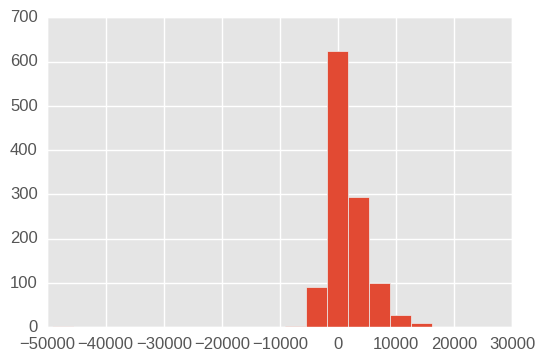

In [20]:
plot_data = ef.fl_day1_balance_ml.values
plot_data = plot_data[~np.isnan(plot_data)]
print(pd.Series(plot_data).describe())
_ = plt.hist(plot_data, bins=20)

 0.0     621
 3.0     140
-1.0     114
 1.0      91
 2.0      62
-50.0      5
Name: ea_lv_systolic, dtype: int64

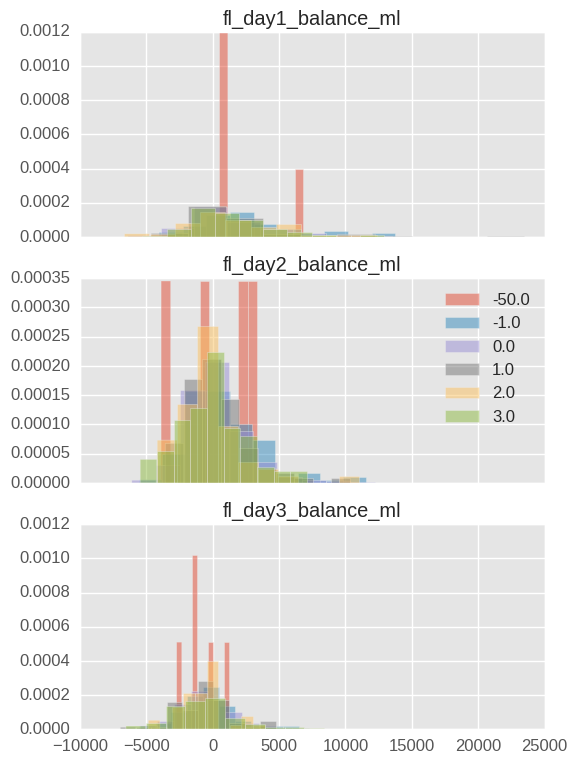

In [21]:
## if we group by echo lv systolic, what do the fluid distributions look like?
display(ef.ea_lv_systolic.value_counts())
fig, axs = plt.subplots(3, sharex=True, figsize=(6, 9))
for i,fluid_day in enumerate(['fl_day1_balance_ml', 'fl_day2_balance_ml', 'fl_day3_balance_ml']):
    ax = axs[i]
    for name,group in ef.groupby('ea_lv_systolic'):
        fluid = group[fluid_day].values.copy()
        # filter out less than -7 litres
        fluid[fluid < -7000] = np.nan
        fluid = fluid[~np.isnan(fluid)]
        ax.hist(fluid, alpha=0.5, label=str(name), normed=True)
    ax.set_title(fluid_day)
    if i == 1:
        ax.legend(loc='best')

## Fluid management following echo by LV systolic

In [22]:
to_plot = ef[['fl_day1_balance_ml', 'fl_day2_balance_ml', 'fl_day3_balance_ml']].stack().reset_index()
to_plot.columns = ['row_id', 'Day', 'Fluid balance (ml)']
to_plot.loc[to_plot['Day'] == 'fl_day1_balance_ml', 'Day'] = 1
to_plot.loc[to_plot['Day'] == 'fl_day2_balance_ml', 'Day'] = 2
to_plot.loc[to_plot['Day'] == 'fl_day3_balance_ml', 'Day'] = 3
to_plot = to_plot.loc[to_plot['Fluid balance (ml)'] >= -7000]
to_plot = pd.merge(to_plot, ef[['ea_lv_systolic']], left_on = 'row_id', right_index = True)
to_plot = pd.merge(to_plot, ef[['ex_congestive_heart_failure']], left_on = 'row_id', right_index = True)
to_plot = pd.merge(to_plot, ef[['day30_mortality']], left_on='row_id', right_index=True)
to_plot = pd.merge(to_plot, ef[['mech_vent']], left_on='row_id', right_index=True)

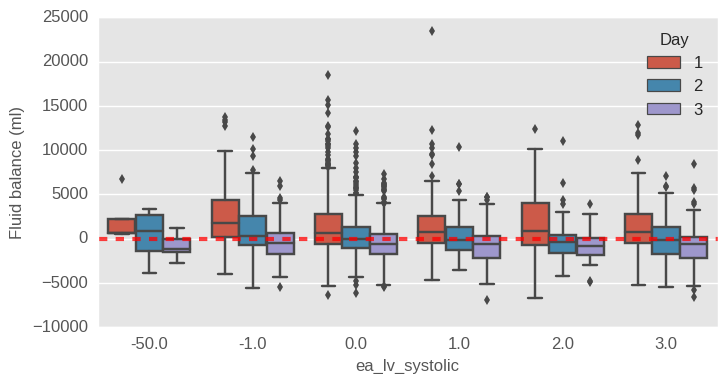

In [23]:
plt.figure(figsize=(8, 4))
sns.boxplot(data = to_plot, x = 'ea_lv_systolic', y = 'Fluid balance (ml)', hue = 'Day')
plt.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)

In [24]:
from scipy.stats import ttest_ind
group_0 = ef.loc[ef.ea_lv_systolic == 0].fl_day1_balance_ml.dropna()
group_1 = ef.loc[ef.ea_lv_systolic == 3].fl_day1_balance_ml.dropna()
print(group_0.mean(), group_1.mean())
print(group_0.std(), group_1.std())
ttest_ind(group_0, group_1, equal_var=True)

1326.2137655 1454.37877294
3300.2702684 2980.56917917


Ttest_indResult(statistic=-0.40093911182784192, pvalue=0.68858490469018485)

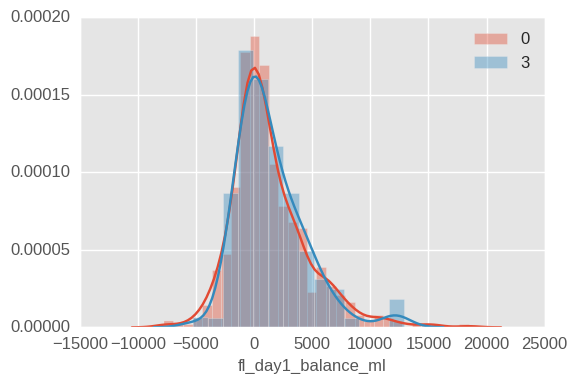

In [25]:
sns.distplot(group_0, label='0')
sns.distplot(group_1, label='3')
plt.legend()

## Congestive heart failure changes fluid management depending on LV systolic

In [29]:
from scipy.stats import ttest_ind
from scipy.stats import pearsonr

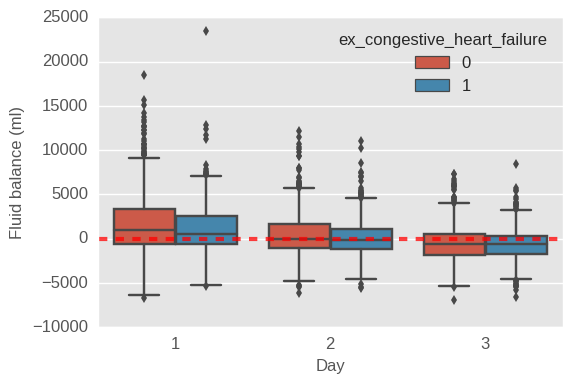

In [34]:
g = sns.boxplot(data=to_plot, x='Day', y='Fluid balance (ml)', hue='ex_congestive_heart_failure')
_ = plt.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)

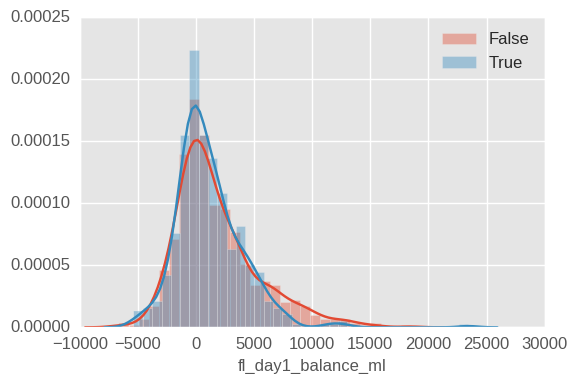

1795.68553556 3563.34556875
1143.17936917 2865.52552644
Ttest_indResult(statistic=3.4369931070995881, pvalue=0.00060963043091683683)
-0.0971426823389 0.000962162511772


In [35]:
filter = (ef.fl_day1_balance_ml >= -7000)
group_0 = ef.loc[filter & (ef.ex_congestive_heart_failure == False)].fl_day1_balance_ml
group_0 = group_0.dropna()
group_1 = ef.loc[filter & (ef.ex_congestive_heart_failure == True)].fl_day1_balance_ml
group_1 = group_1.dropna()

f = plt.figure()
sns.distplot(group_0, label='False')
sns.distplot(group_1, label='True')
plt.legend()
display(f)
plt.close()
print(group_0.mean(), group_0.std())
print(group_1.mean(), group_1.std())

stats = {}
ttest = ttest_ind(group_0, group_1, equal_var=False)
print(ttest)
stats['t-test p-value'] = ttest.pvalue
data = ef.loc[filter,['fl_day1_balance_ml', 'ex_congestive_heart_failure']].dropna()
r, pval = pearsonr(data.fl_day1_balance_ml, data.ex_congestive_heart_failure)
print(r, pval)

In [26]:
counts = ef.groupby('ex_congestive_heart_failure').apply(lambda x: x['ea_lv_systolic'].value_counts())
counts = counts.unstack().T
counts.index.name = 'ea_lv_systolic'
counts

ex_congestive_heart_failure,0,1
ea_lv_systolic,,
-50.0,5.0,NaN
-1.0,85.0,29.0
0.0,416.0,205.0
1.0,51.0,40.0
2.0,17.0,45.0
3.0,49.0,91.0


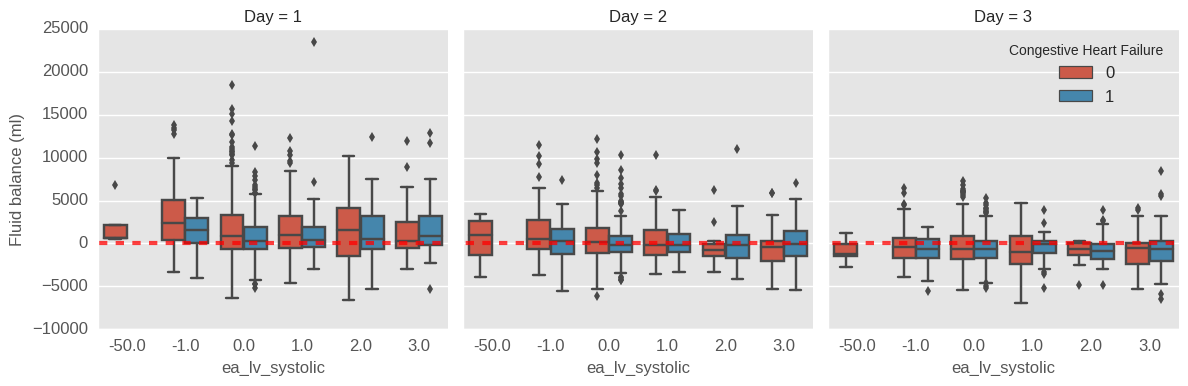

In [27]:
g  = sns.factorplot(data=to_plot, x='ea_lv_systolic', y='Fluid balance (ml)', kind='box', legend=False
               #, hue='Day', col='ex_congestive_heart_failure')
               , hue='ex_congestive_heart_failure', col='Day')
for ax in g.axes.ravel():
    ax.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)
plt.legend(loc='best', title='Congestive Heart Failure')

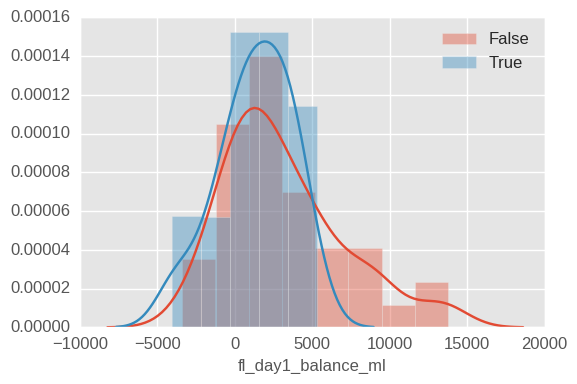

LV systolic: -1
3174.92820577 3900.11490037
1312.70288982 2395.17196446
Ttest_indResult(statistic=2.9629251011286435, pvalue=0.0040448228348963378)
-0.224391780046 0.0195607542219



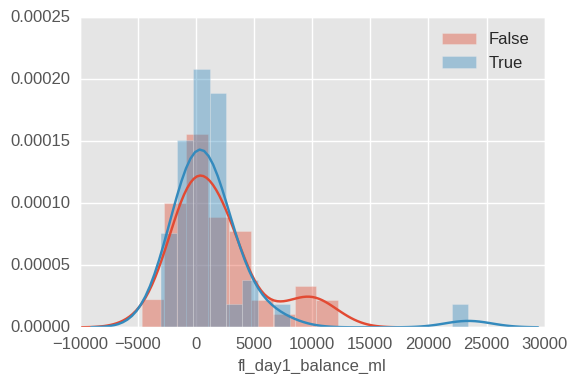

LV systolic: 1
1907.09304487 3829.02747148
1336.36928522 4197.15261317
Ttest_indResult(statistic=0.65081089429232486, pvalue=0.51713435925873164)
-0.0715941790723 0.512427152145



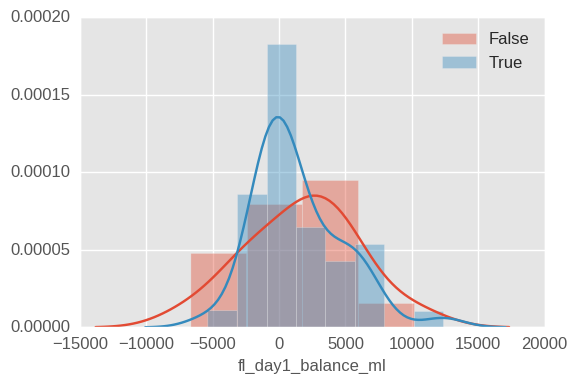

LV systolic: 2
1740.81095119 4250.09001038
1439.94367772 3351.79098007
Ttest_indResult(statistic=0.24800728872982009, pvalue=0.80658847754047391)
-0.0374202281439 0.782275979948



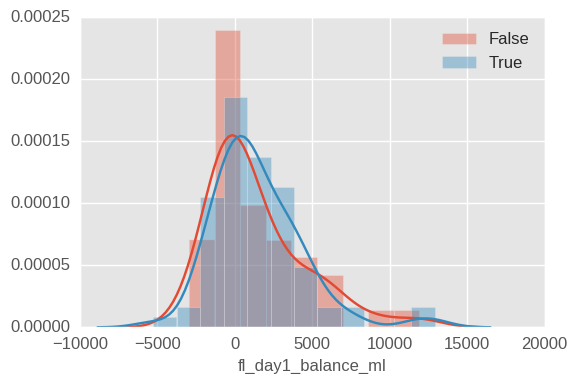

LV systolic: 3
1406.04456659 3131.06300507
1479.72475919 2917.98979265
Ttest_indResult(statistic=-0.12790716387617071, pvalue=0.89854210991169836)
0.0117903541704 0.89617054589



,LV Systolic,Pearson r,t-test p-value
0,-1,-0.224392,0.004045
1,1,-0.071594,0.517134
2,2,-0.037420,0.806588
3,3,0.011790,0.898542


In [30]:
statistics = []
for systolic_flag in [-1,1,2,3]:
    filter = (ef.ea_lv_systolic == systolic_flag) & (ef.fl_day1_balance_ml >= -7000)
    group_0 = ef.loc[filter & (ef.ex_congestive_heart_failure == False)].fl_day1_balance_ml
    group_0 = group_0.dropna()
    group_1 = ef.loc[filter & (ef.ex_congestive_heart_failure == True)].fl_day1_balance_ml
    group_1 = group_1.dropna()

    f = plt.figure()
    sns.distplot(group_0, label='False')
    sns.distplot(group_1, label='True')
    plt.legend()
    display(f)
    plt.close()
    print('LV systolic:', systolic_flag)
    print(group_0.mean(), group_0.std())
    print(group_1.mean(), group_1.std())

    stats = {}
    ttest = ttest_ind(group_0, group_1, equal_var=False)
    print(ttest)
    stats['t-test p-value'] = ttest.pvalue
    data = ef.loc[filter,['fl_day1_balance_ml', 'ex_congestive_heart_failure']].dropna()
    r, pval = pearsonr(data.fl_day1_balance_ml, data.ex_congestive_heart_failure)
    print(r, pval)
    stats['Pearson r'] = r
    stats['LV Systolic'] = systolic_flag
    statistics.append(stats)
    print('')
statistics = pd.DataFrame(statistics)
statistics

In [31]:
from scipy.stats import ttest_ind
filter = (ef.ea_lv_systolic == 3)
group_0 = ef.loc[filter & (ef.ex_congestive_heart_failure == 0)].fl_day1_balance_ml.dropna()
group_1 = ef.loc[filter & (ef.ex_congestive_heart_failure == 1)].fl_day1_balance_ml.dropna()
print(group_0.mean(), group_1.mean())
print(group_0.std(), group_1.std())
ttest_ind(group_0, group_1, equal_var=False)

1406.04456659 1479.72475919
3131.06300507 2917.98979265


Ttest_indResult(statistic=-0.12790716387617071, pvalue=0.89854210991169836)

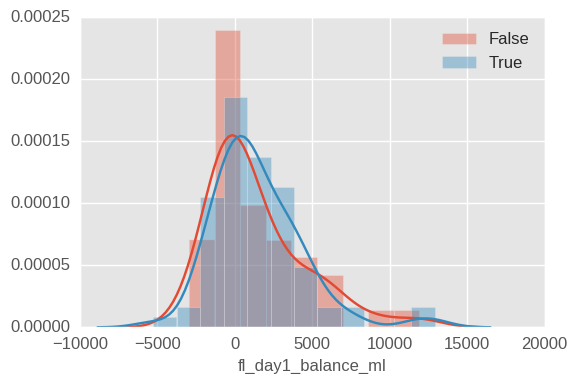

In [32]:
sns.distplot(group_0, label='False')
sns.distplot(group_1, label='True')
plt.legend()

## Fluid management by LV systolic and 30-day mortality

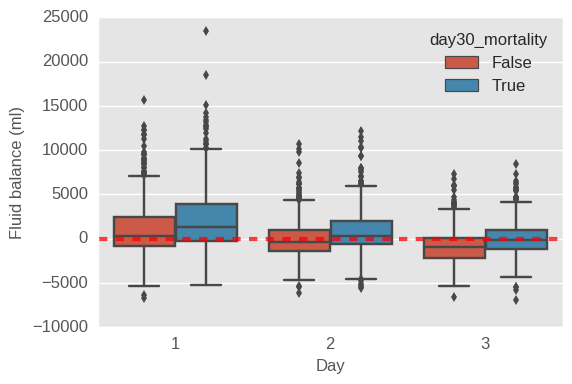

In [39]:
g = sns.boxplot(data=to_plot, x='Day', y='Fluid balance (ml)', hue='day30_mortality')
_ = plt.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)

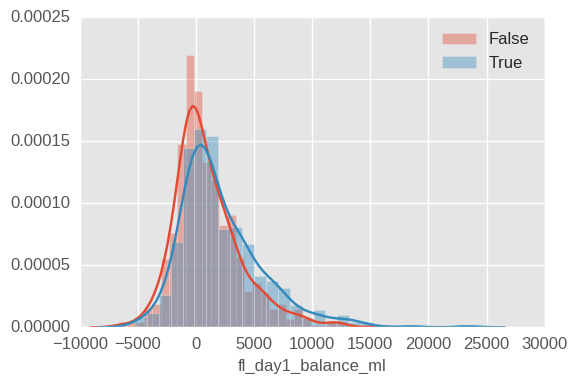

1030.06263824 2955.26840053
2188.07306067 3624.93050583
Ttest_indResult(statistic=-5.7993093191008915, pvalue=9.1094201895390131e-09)
0.173329794151 3.1902567943e-09


In [41]:
filter = (ef.fl_day1_balance_ml >= -7000)
group_0 = ef.loc[filter & (ef.day30_mortality == False)].fl_day1_balance_ml
group_0 = group_0.dropna()
group_1 = ef.loc[filter & (ef.day30_mortality == True)].fl_day1_balance_ml
group_1 = group_1.dropna()

f = plt.figure()
sns.distplot(group_0, label='False')
sns.distplot(group_1, label='True')
plt.legend()
display(f)
plt.close()
print(group_0.mean(), group_0.std())
print(group_1.mean(), group_1.std())

stats = {}
ttest = ttest_ind(group_0, group_1, equal_var=False)
print(ttest)
stats['t-test p-value'] = ttest.pvalue
data = ef.loc[filter,['fl_day1_balance_ml', 'day30_mortality']].dropna()
r, pval = pearsonr(data.fl_day1_balance_ml, data.day30_mortality)
print(r, pval)

In [42]:
counts = ef.groupby('ea_lv_systolic').apply(lambda x: x['day30_mortality'].value_counts())
counts = counts.T
counts.index.name = 'day30_mortality'
counts

ea_lv_systolic       
-50.0           False      4
                True       1
-1.0            True      62
                False     52
 0.0            False    378
                True     243
 1.0            False     56
                True      35
 2.0            False     32
                True      30
 3.0            True      82
                False     58
Name: day30_mortality, dtype: int64

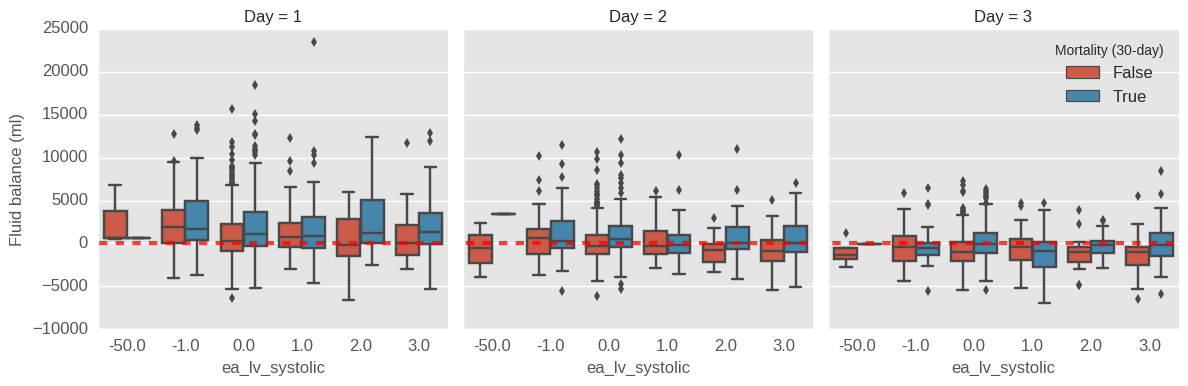

In [43]:
g  = sns.factorplot(data=to_plot, x='ea_lv_systolic', y='Fluid balance (ml)', kind='box', legend=False
               #, hue='Day', col='ex_congestive_heart_failure')
               , hue='day30_mortality', col='Day')
for ax in g.axes.ravel():
    ax.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)
plt.legend(loc='best', title='Mortality (30-day)')

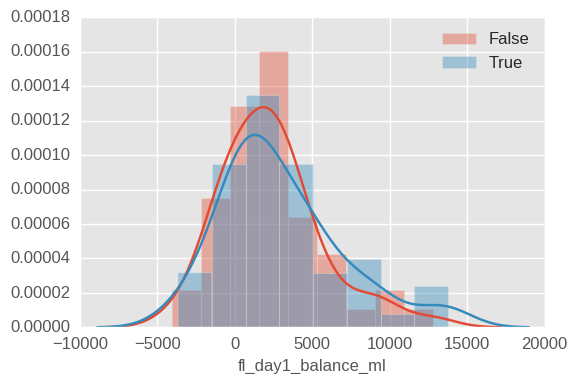

LV systolic: -1
2309.04695959 3277.54186493
3022.37223098 3948.01154378
Ttest_indResult(statistic=-1.025774481378531, pvalue=0.3073361042820375)
0.0977996538057 0.313957077228



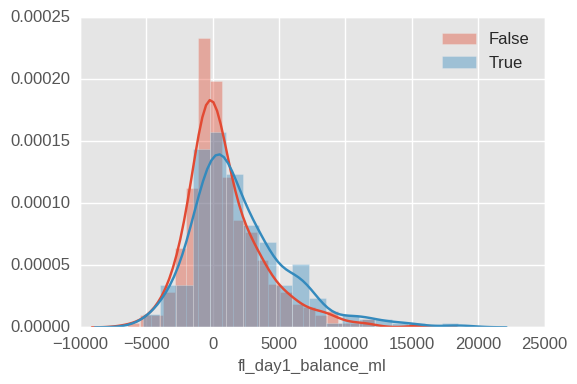

LV systolic: 0
920.294985124 2932.48627601
2018.59379925 3618.47438055
Ttest_indResult(statistic=-3.8787504963616133, pvalue=0.00012159643521064708)
0.164786350934 5.86297303164e-05



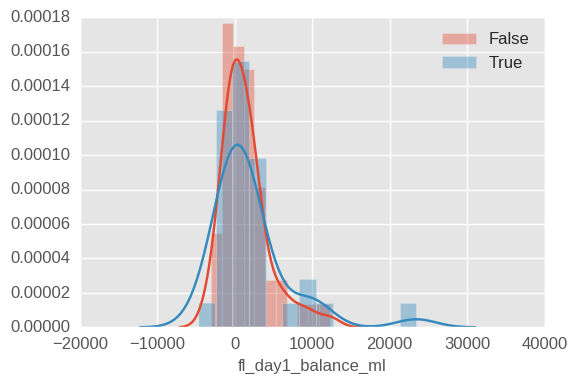

LV systolic: 1
1372.25085308 3019.64201333
2108.88496299 5191.96498675
Ttest_indResult(statistic=-0.74075458255496918, pvalue=0.46263544231299925)
0.0904869757518 0.407351088281



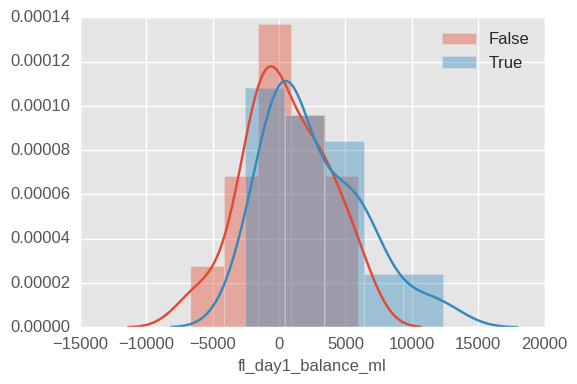

LV systolic: 2
450.840474754 3144.58255278
2625.55089158 3703.1164227
Ttest_indResult(statistic=-2.3860031237208665, pvalue=0.020641322117569274)
0.307072309437 0.0201562762034



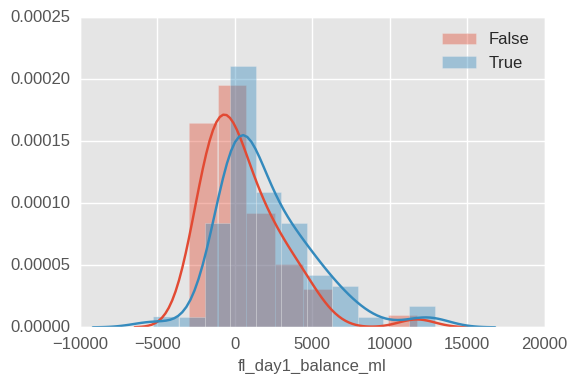

LV systolic: 3
580.183644131 2617.06921407
2097.88352053 3083.62561158
Ttest_indResult(statistic=-2.9690789914720286, pvalue=0.003605074633918951)
0.252653329852 0.00447413260641



,LV systolic,Pearson r,t-test p-value
0,-1,0.097800,0.307336
1,0,0.164786,0.000122
2,1,0.090487,0.462635
3,2,0.307072,0.020641
4,3,0.252653,0.003605


In [45]:
statistics = []
for systolic_flag in [-1, 0, 1, 2, 3]:
    filter = (ef.ea_lv_systolic == systolic_flag) & (ef.fl_day1_balance_ml >= -7000)
    group_0 = ef.loc[filter & (ef.day30_mortality == False)].fl_day1_balance_ml
    group_0 = group_0.dropna()
    group_1 = ef.loc[filter & (ef.day30_mortality == True)].fl_day1_balance_ml
    group_1 = group_1.dropna()

    f = plt.figure()
    sns.distplot(group_0, label='False')
    sns.distplot(group_1, label='True')
    plt.legend()
    display(f)
    plt.close()
    print('LV systolic:', systolic_flag)
    print(group_0.mean(), group_0.std())
    print(group_1.mean(), group_1.std())

    stats = {}
    ttest = ttest_ind(group_0, group_1, equal_var=False)
    print(ttest)
    stats['t-test p-value'] = ttest.pvalue
    data = ef.loc[filter,['fl_day1_balance_ml', 'day30_mortality']].dropna()
    r, pval = pearsonr(data.fl_day1_balance_ml, data.day30_mortality)
    print(r, pval)
    stats['Pearson r'] = r
    stats['LV systolic'] = systolic_flag
    statistics.append(stats)
    print('')
statistics = pd.DataFrame(statistics)
statistics

### Break down by congestive heart failure

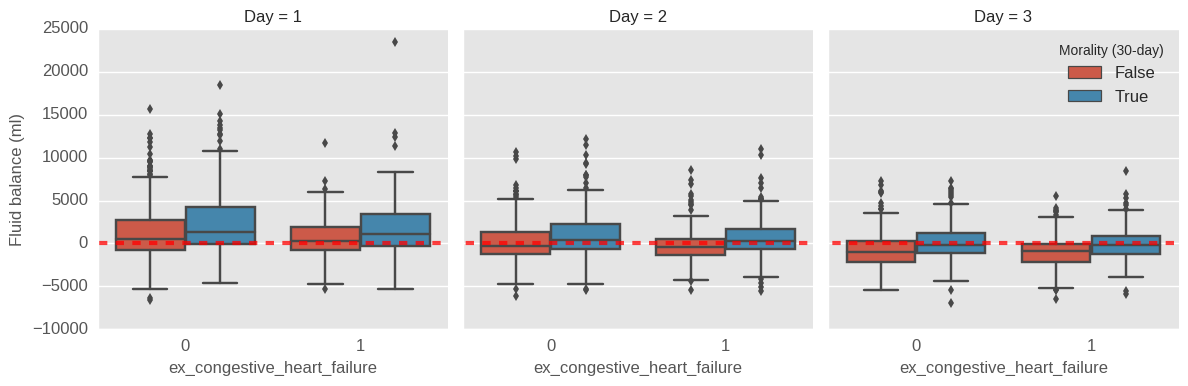

In [47]:
g  = sns.factorplot(data=to_plot, x='ex_congestive_heart_failure', y='Fluid balance (ml)', kind='box', legend=False
               #, hue='Day', col='ex_congestive_heart_failure')
               , hue='day30_mortality', col='Day')
for ax in g.axes.ravel():
    ax.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)
plt.legend(loc='best', title='Morality (30-day)')

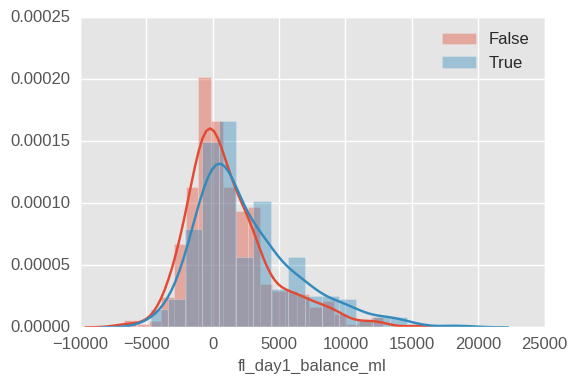

1264.25750183 3249.45183646
2567.79655559 3852.79179983
Ttest_indResult(statistic=-4.6054223041320395, pvalue=5.1733146240998633e-06)
0.179897509235 2.46955652522e-06


In [48]:
# is the difference significant for non CHF patients
filter = (ef.ex_congestive_heart_failure == 0) & (ef.fl_day1_balance_ml >= -7000)
group_0 = ef.loc[filter & (ef.day30_mortality == False)].fl_day1_balance_ml
group_0 = group_0.dropna()
group_1 = ef.loc[filter & (ef.day30_mortality == True)].fl_day1_balance_ml
group_1 = group_1.dropna()

f = plt.figure()
sns.distplot(group_0, label='False')
sns.distplot(group_1, label='True')
plt.legend()
display(f)
plt.close()
print(group_0.mean(), group_0.std())
print(group_1.mean(), group_1.std())

stats = {}
ttest = ttest_ind(group_0, group_1, equal_var=False)
print(ttest)
stats['t-test p-value'] = ttest.pvalue
data = ef.loc[filter,['fl_day1_balance_ml', 'day30_mortality']].dropna()
r, pval = pearsonr(data.fl_day1_balance_ml, data.day30_mortality)
print(r, pval)

In [46]:
counts = ef.groupby(['ex_congestive_heart_failure', 'ea_lv_systolic']).apply(lambda x: x['day30_mortality'].value_counts())
counts = counts.unstack().T
counts.index.name = 'day30_mortality'
counts

ex_congestive_heart_failure     0                                   1        \
ea_lv_systolic              -50.0 -1.0   0.0   1.0   2.0   3.0  -1.0   0.0    
day30_mortality                                                               
False                           4    38   258    30    10    23    14   120   
True                            1    47   158    21     7    26    15    85   

ex_congestive_heart_failure                    
ea_lv_systolic               1.0   2.0   3.0   
day30_mortality                                
False                          26    22    35  
True                           14    23    56

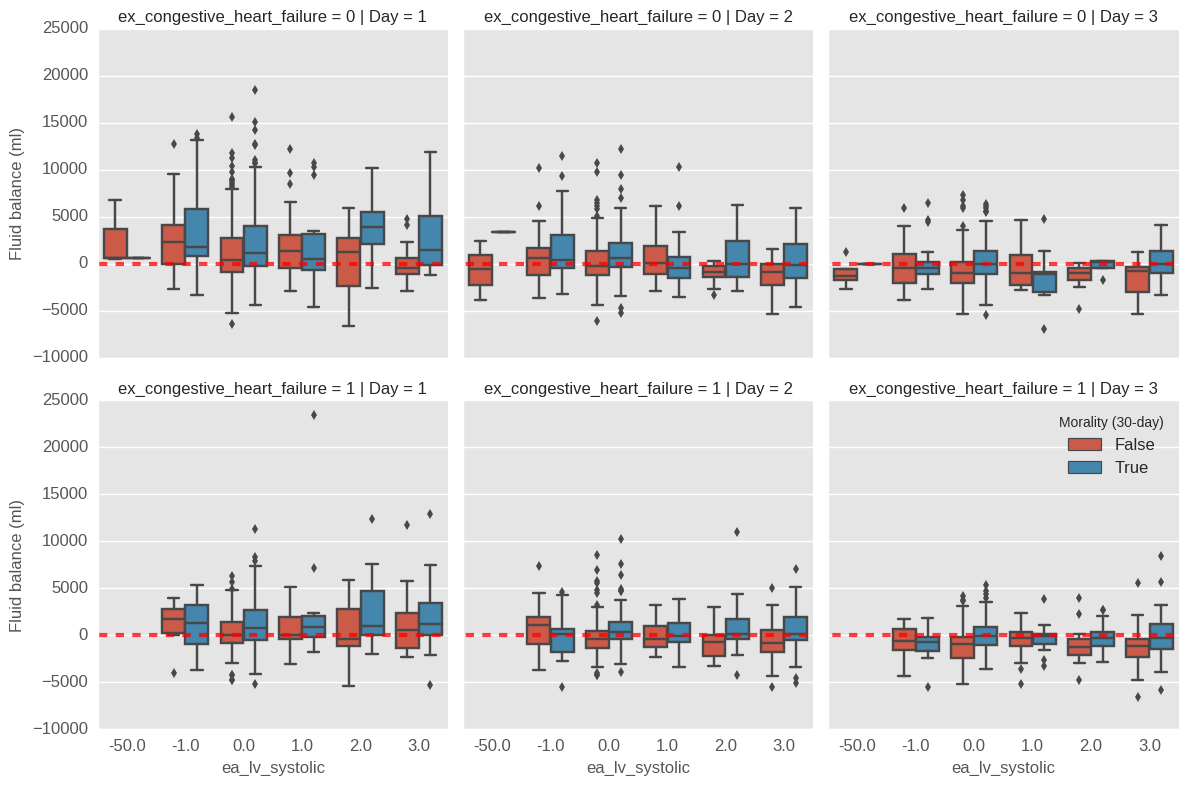

In [49]:
g  = sns.factorplot(data=to_plot, x='ea_lv_systolic', y='Fluid balance (ml)', kind='box', legend=False
               #, hue='Day', col='ex_congestive_heart_failure')
               , hue='day30_mortality', col='Day', row='ex_congestive_heart_failure')
for ax in g.axes.ravel():
    ax.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)
plt.legend(loc='best', title='Morality (30-day)')

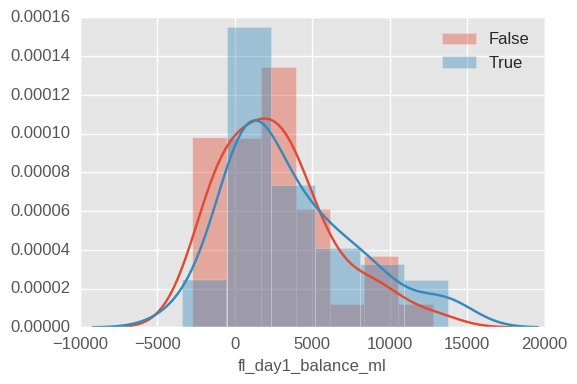

LV systolic: -1
2641.48134013 3569.40402998
3633.94062504 4150.18324062
Ttest_indResult(statistic=-1.1499093341746704, pvalue=0.2536947196680191)
0.127676758441 0.259054405984



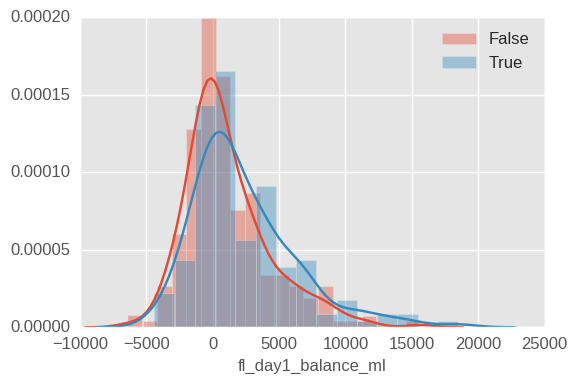

LV systolic: 0
1158.3892764 3227.22195359
2379.37839824 3885.22869662
Ttest_indResult(statistic=-3.2267610854436111, pvalue=0.001403179140871618)
0.168022904804 0.00083828296493



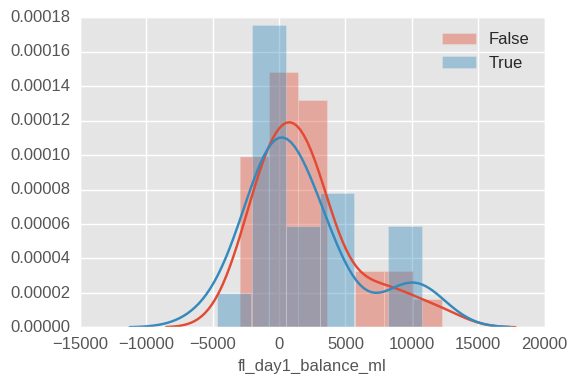

LV systolic: 1
2021.09520697 3676.74458336
1747.49001794 4124.48836167
Ttest_indResult(statistic=0.23694560647873264, pvalue=0.81396967738520365)
-0.03560084558 0.810156326919



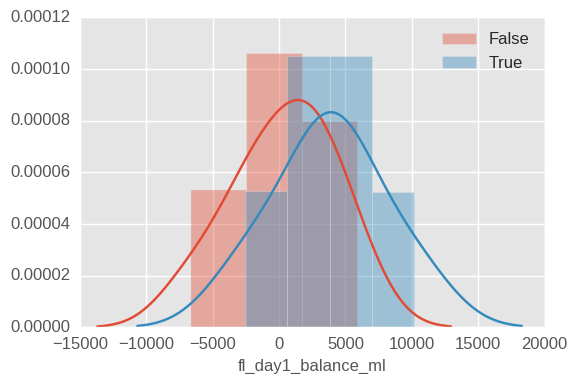

LV systolic: 2
356.661048965 3866.0482001
3817.03580452 4247.5401222
Ttest_indResult(statistic=-1.6016759077716474, pvalue=0.13995120195335461)
0.412868966136 0.126140321011



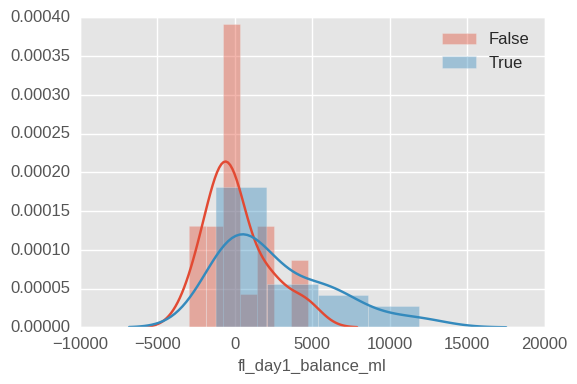

LV systolic: 3
115.124764117 1980.79268125
2638.28619622 3551.50779261
Ttest_indResult(statistic=-2.8939546417874888, pvalue=0.0066722781710162136)
0.407582328012 0.0066707067666



,LV systolic,Pearson r,t-test p-value
0,-1,0.127677,0.253695
1,0,0.168023,0.001403
2,1,-0.035601,0.813970
3,2,0.412869,0.139951
4,3,0.407582,0.006672


In [50]:
statistics = []
for systolic_flag in [-1, 0, 1, 2, 3]:
    filter = (ef.ex_congestive_heart_failure == 0) & (ef.ea_lv_systolic == systolic_flag)
    filter &= (ef.fl_day1_balance_ml >= -7000)
    group_0 = ef.loc[filter & (ef.day30_mortality == False)].fl_day1_balance_ml
    group_0 = group_0.dropna()
    group_1 = ef.loc[filter & (ef.day30_mortality == True)].fl_day1_balance_ml
    group_1 = group_1.dropna()

    f = plt.figure()
    sns.distplot(group_0, label='False')
    sns.distplot(group_1, label='True')
    plt.legend()
    display(f)
    plt.close()
    print('LV systolic:', systolic_flag)
    print(group_0.mean(), group_0.std())
    print(group_1.mean(), group_1.std())

    stats = {}
    ttest = ttest_ind(group_0, group_1, equal_var=False)
    print(ttest)
    stats['t-test p-value'] = ttest.pvalue
    data = ef.loc[filter,['fl_day1_balance_ml', 'day30_mortality']].dropna()
    r, pval = pearsonr(data.fl_day1_balance_ml, data.day30_mortality)
    print(r, pval)
    stats['Pearson r'] = r
    stats['LV systolic'] = systolic_flag
    statistics.append(stats)
    print('')
statistics = pd.DataFrame(statistics)
statistics

### Break down by mechanical ventilation

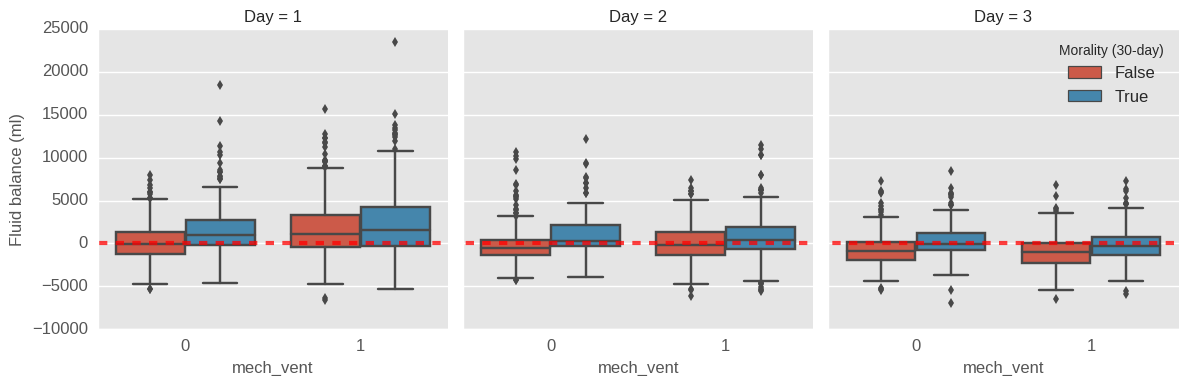

In [51]:
g  = sns.factorplot(data=to_plot, x='mech_vent', y='Fluid balance (ml)', kind='box', legend=False
               #, hue='Day', col='ex_congestive_heart_failure')
               , hue='day30_mortality', col='Day')
for ax in g.axes.ravel():
    ax.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)
plt.legend(loc='best', title='Morality (30-day)')

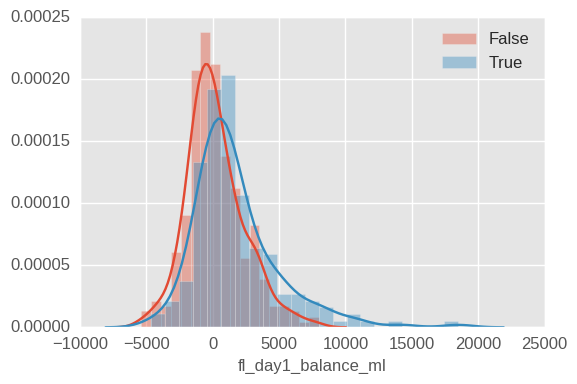

mech_vent = 0
219.159318894 2181.59812261
1732.23966104 3229.71167788
Ttest_indResult(statistic=-5.5676240404138229, pvalue=6.2163276112223058e-08)
0.268998538173 1.43754084128e-09



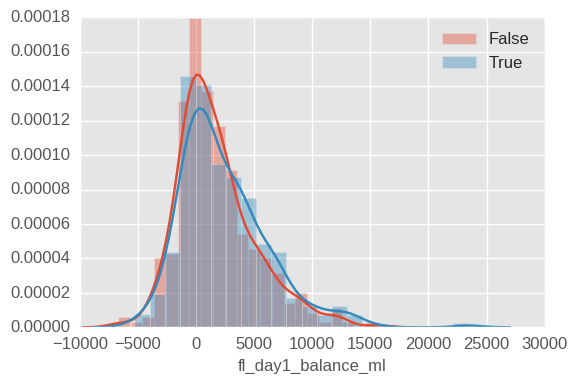

mech_vent = 1
1761.28181638 3348.22411482
2444.83997565 3810.58129388
Ttest_indResult(statistic=-2.4420324966026774, pvalue=0.014878791080679687)
0.0951785175588 0.0142928443322



In [52]:
for flag in [0,1]:
    filter = (ef.mech_vent == flag) & (ef.fl_day1_balance_ml >= -7000)
    group_0 = ef.loc[filter & (ef.day30_mortality == False)].fl_day1_balance_ml
    group_0 = group_0.dropna()
    group_1 = ef.loc[filter & (ef.day30_mortality == True)].fl_day1_balance_ml
    group_1 = group_1.dropna()

    f = plt.figure()
    sns.distplot(group_0, label='False')
    sns.distplot(group_1, label='True')
    plt.legend()
    display(f)
    plt.close()
    print('mech_vent =', flag)
    print(group_0.mean(), group_0.std())
    print(group_1.mean(), group_1.std())

    stats = {}
    ttest = ttest_ind(group_0, group_1, equal_var=False)
    print(ttest)
    stats['t-test p-value'] = ttest.pvalue
    data = ef.loc[filter,['fl_day1_balance_ml', 'day30_mortality']].dropna()
    r, pval = pearsonr(data.fl_day1_balance_ml, data.day30_mortality)
    print(r, pval)
    print('')

In [53]:
counts = ef.groupby(['mech_vent', 'ea_lv_systolic']).apply(lambda x: x['day30_mortality'].value_counts())
counts = counts.unstack().T
counts.index.name = 'day30_mortality'
counts

mech_vent           0                                    1                     \
ea_lv_systolic  -50.0 -1.0    0.0   1.0   2.0   3.0  -50.0 -1.0    0.0   1.0    
day30_mortality                                                                 
False             2.0  18.0  202.0  26.0  15.0  24.0   2.0  34.0  176.0  30.0   
True              NaN  32.0   98.0  13.0   9.0  27.0   1.0  30.0  145.0  22.0   

mech_vent                    
ea_lv_systolic   2.0   3.0   
day30_mortality              
False            17.0  34.0  
True             21.0  55.0

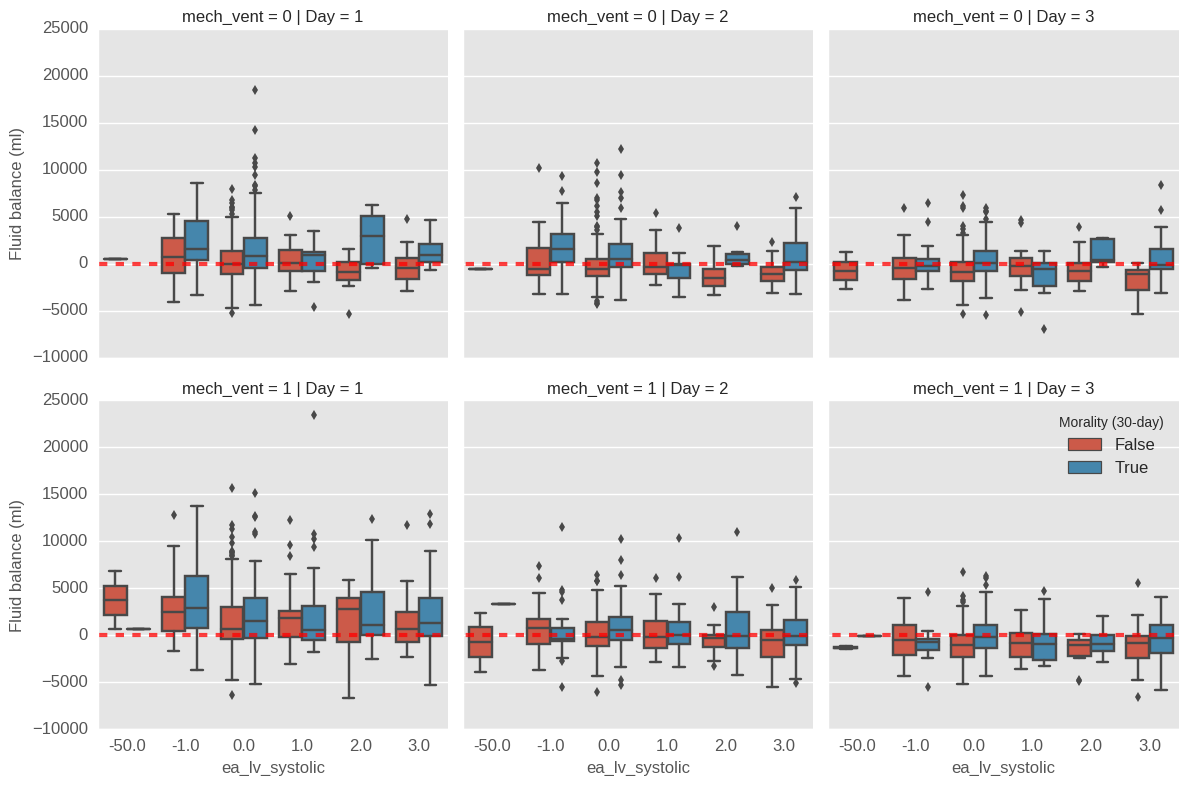

In [54]:
g  = sns.factorplot(data=to_plot, x='ea_lv_systolic', y='Fluid balance (ml)', kind='box', legend=False
               #, hue='Day', col='ex_congestive_heart_failure')
               , hue='day30_mortality', col='Day', row='mech_vent')
for ax in g.axes.ravel():
    ax.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)
plt.legend(loc='best', title='Morality (30-day)')

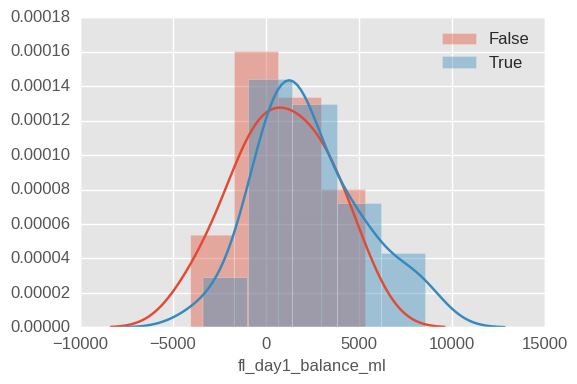

LV systolic: -1
875.859141852 2572.88010486
2324.26350556 2825.02479943
Ttest_indResult(statistic=-1.7450264906360828, pvalue=0.09011540491642836)
0.250621439334 0.0968079332066



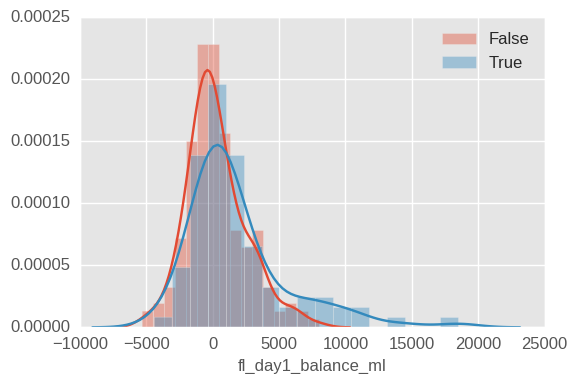

LV systolic: 0
288.119645955 2245.75519703
1855.44484276 3846.67116102
Ttest_indResult(statistic=-3.5969708173571862, pvalue=0.00046722719712399423)
0.24936961735 2.78431785229e-05



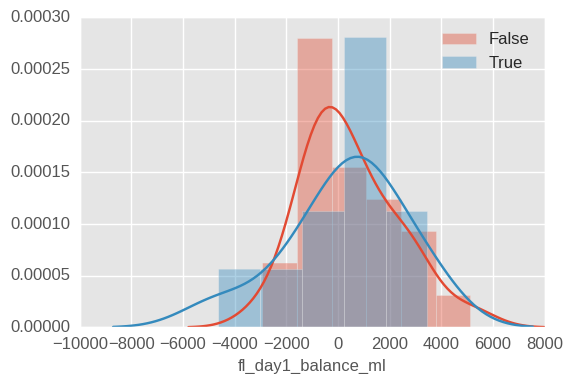

LV systolic: 1
468.257145224 1845.69086624
297.028088616 2305.71391462
Ttest_indResult(statistic=0.21654758616198369, pvalue=0.8312757362141785)
-0.0409726383099 0.815223968706



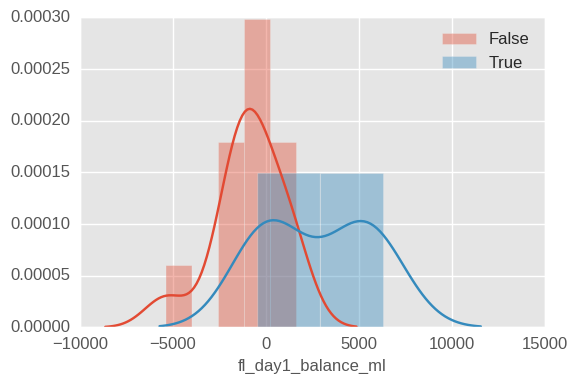

LV systolic: 2
-896.284005187 1868.77623526
2798.4099041 2853.57527217
Ttest_indResult(statistic=-3.2294393560527848, pvalue=0.0080207850762432208)
0.638069214405 0.00246852891588



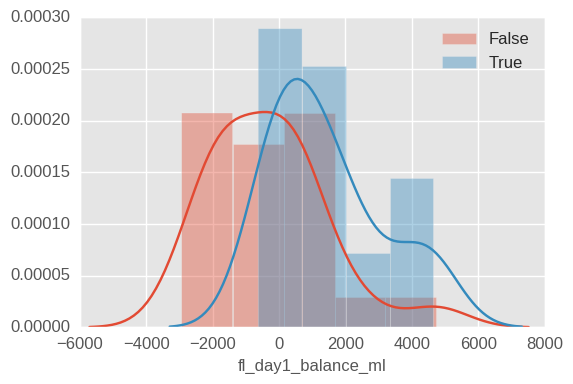

LV systolic: 3
-332.34294225 1756.42122504
1421.34820637 1673.91002941
Ttest_indResult(statistic=-3.3523637762080174, pvalue=0.0017317902256167544)
0.463410573066 0.00175068149799



,LV systolic,Pearson r,t-test p-value
0,-1,0.250621,0.090115
1,0,0.249370,0.000467
2,1,-0.040973,0.831276
3,2,0.638069,0.008021
4,3,0.463411,0.001732


In [56]:
statistics = []
for systolic_flag in [-1, 0, 1, 2, 3]:
    filter = (ef.mech_vent == 0) & (ef.ea_lv_systolic == systolic_flag)
    filter &= (ef.fl_day1_balance_ml >= -7000)
    group_0 = ef.loc[filter & (ef.day30_mortality == False)].fl_day1_balance_ml
    group_0 = group_0.dropna()
    group_1 = ef.loc[filter & (ef.day30_mortality == True)].fl_day1_balance_ml
    group_1 = group_1.dropna()

    f = plt.figure()
    sns.distplot(group_0, label='False')
    sns.distplot(group_1, label='True')
    plt.legend()
    display(f)
    plt.close()
    print('LV systolic:', systolic_flag)
    print(group_0.mean(), group_0.std())
    print(group_1.mean(), group_1.std())

    stats = {}
    ttest = ttest_ind(group_0, group_1, equal_var=False)
    print(ttest)
    stats['t-test p-value'] = ttest.pvalue
    data = ef.loc[filter,['fl_day1_balance_ml', 'day30_mortality']].dropna()
    r, pval = pearsonr(data.fl_day1_balance_ml, data.day30_mortality)
    print(r, pval)
    stats['Pearson r'] = r
    stats['LV systolic'] = systolic_flag
    statistics.append(stats)
    print('')
statistics = pd.DataFrame(statistics)
statistics

### Calculate MDRD and breakdown fluid management

In [57]:
def mdrd(data):
    creat = data.lab_creatinine
    age = data.age_at_intime/np.timedelta64('1', 'Y')
    age.loc[age<0] = age.max()
    gender = data.gender.apply(lambda x: 0.742 if x == 'F' else 1)
    ethnicity = data.ethnicity.apply(lambda x: 1.212 if 'AFRICAN AMERICAN' in x else 1)
    return 175*creat**(-1.154) * age**(-0.203) * gender * ethnicity

In [58]:
value = mdrd(ef)
ef['mdrd'] = value
discrete = pd.cut(value, [0, 15, 30, 44, 60, 90, 1000000], labels=[5, 4, 3, 2, 1, 0], include_lowest=True)
ef['mdrd_discrete'] = discrete
discrete.value_counts()

0    253
4    241
1    230
2    219
3    177
5    106
dtype: int64

In [61]:
to_plot = pd.merge(to_plot, ef[['mdrd_discrete']], left_on='row_id', right_index=True)

In [62]:
counts = ef.groupby('day30_mortality').apply(lambda x: x['mdrd_discrete'].value_counts())
counts = counts.unstack()
display(counts)
counts /= counts.sum(axis=0)
counts

,5,4,3,2,1,0
day30_mortality,,,,,,
False,55,99,94,128,152,172
True,51,142,83,91,78,81


,5,4,3,2,1,0
day30_mortality,,,,,,
False,0.518868,0.410788,0.531073,0.584475,0.66087,0.679842
True,0.481132,0.589212,0.468927,0.415525,0.33913,0.320158


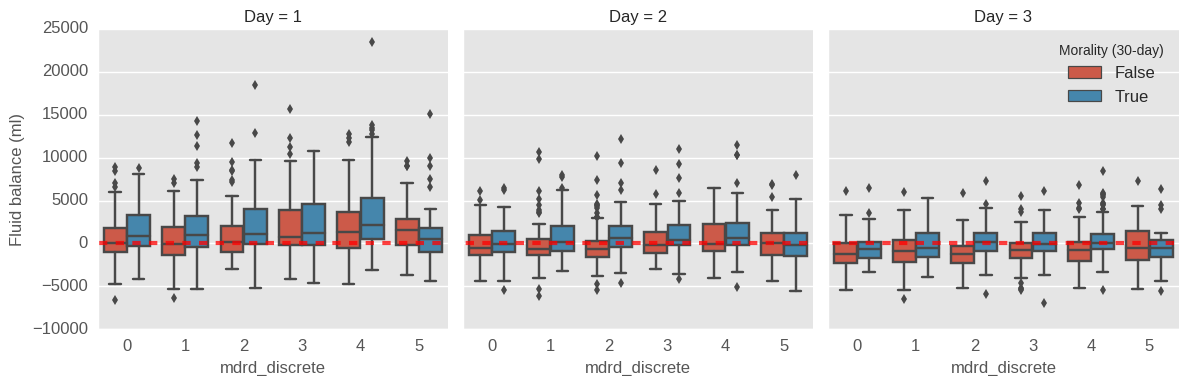

In [63]:
g  = sns.factorplot(data=to_plot, x='mdrd_discrete', y='Fluid balance (ml)', kind='box', legend=False
               #, hue='Day', col='ex_congestive_heart_failure')
               , hue='day30_mortality', col='Day')
for ax in g.axes.ravel():
    ax.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)
plt.legend(loc='best', title='Morality (30-day)')

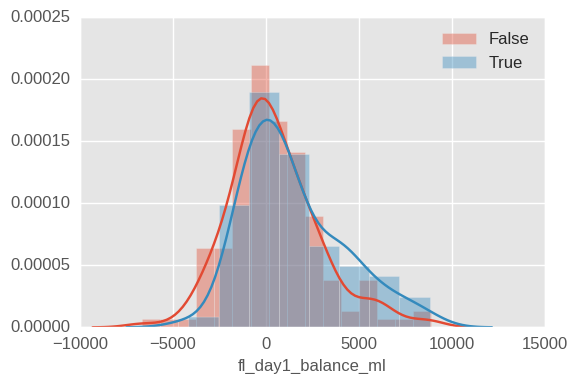

MDRD: 0
462.56592195 2470.18348789
1462.36227897 2667.57327327
Ttest_indResult(statistic=-2.74376757821857, pvalue=0.0068999538369291452)
0.181414384084 0.00518393841548



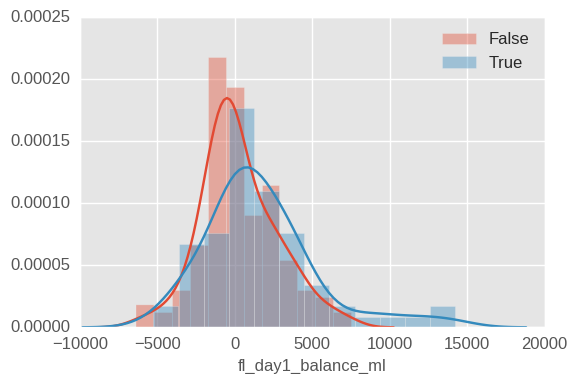

MDRD: 1
284.443703796 2472.43191335
1644.69617811 3619.73114396
Ttest_indResult(statistic=-2.8854589737679981, pvalue=0.0047255566942913064)
0.216895276326 0.00133908720799



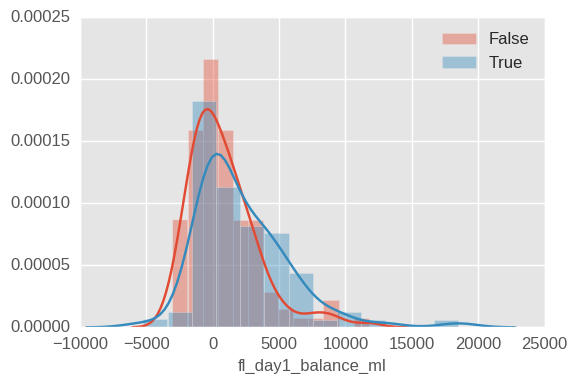

MDRD: 2
844.998614163 2631.9509329
2267.13025162 3512.60928804
Ttest_indResult(statistic=-3.1911635956984972, pvalue=0.0017231078283061576)
0.226503023829 0.000974303498481



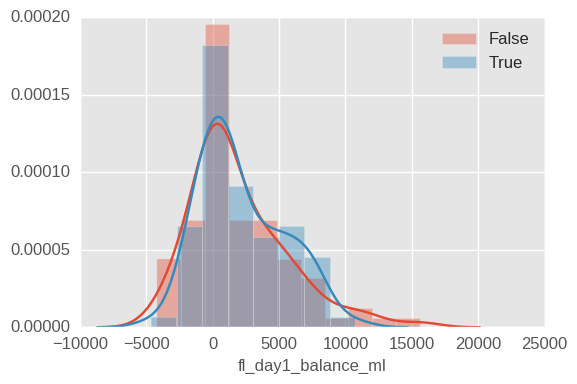

MDRD: 3
2002.91325178 3685.18663231
2150.57951918 3173.01085186
Ttest_indResult(statistic=-0.27897585872367803, pvalue=0.78061159166526251)
0.0214942372706 0.782126365084



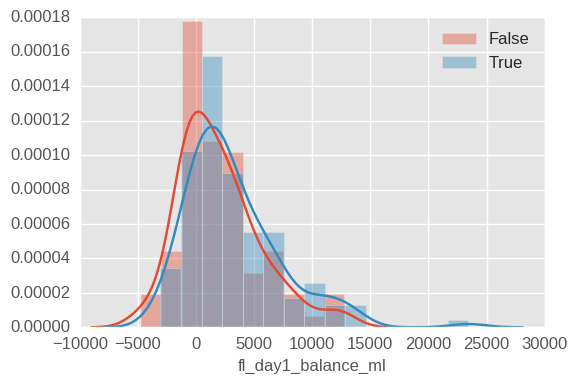

MDRD: 4
2018.03008738 3515.18013083
3236.28470053 4161.90884644
Ttest_indResult(statistic=-2.3553255520015273, pvalue=0.019426759244405904)
0.151610465385 0.0235489712936



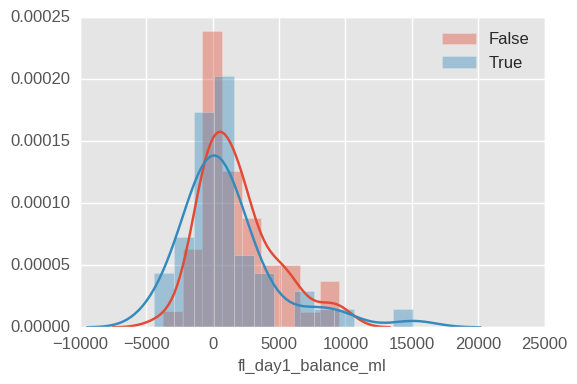

MDRD: 5
1882.66199882 2842.78286966
1118.59872717 3665.92189174
Ttest_indResult(statistic=1.1495098994761268, pvalue=0.25360199978050629)
-0.117655833161 0.243687084363



,LV systolic,Pearson r,t-test p-value
0,3,0.181414,0.006900
1,3,0.216895,0.004726
2,3,0.226503,0.001723
3,3,0.021494,0.780612
4,3,0.151610,0.019427
5,3,-0.117656,0.253602


In [64]:
statistics = []
for flag in range(6):
    filter = (ef.mdrd_discrete == flag)
    filter &= (ef.fl_day1_balance_ml >= -7000)
    group_0 = ef.loc[filter & (ef.day30_mortality == False)].fl_day1_balance_ml
    group_0 = group_0.dropna()
    group_1 = ef.loc[filter & (ef.day30_mortality == True)].fl_day1_balance_ml
    group_1 = group_1.dropna()

    f = plt.figure()
    sns.distplot(group_0, label='False')
    sns.distplot(group_1, label='True')
    plt.legend()
    display(f)
    plt.close()
    print('MDRD:', flag)
    print(group_0.mean(), group_0.std())
    print(group_1.mean(), group_1.std())

    stats = {}
    ttest = ttest_ind(group_0, group_1, equal_var=False)
    print(ttest)
    stats['t-test p-value'] = ttest.pvalue
    data = ef.loc[filter,['fl_day1_balance_ml', 'day30_mortality']].dropna()
    r, pval = pearsonr(data.fl_day1_balance_ml, data.day30_mortality)
    print(r, pval)
    stats['Pearson r'] = r
    stats['LV systolic'] = systolic_flag
    statistics.append(stats)
    print('')
statistics = pd.DataFrame(statistics)
statistics

In [65]:
counts = ef.groupby('mdrd_discrete').apply(lambda x: x['ea_lv_systolic'].value_counts())
counts = counts.unstack().fillna(0)
#counts.columns.name = 'day30_mortality'
counts

,-50.0,-1.0,0.0,1.0,2.0,3.0
mdrd_discrete,,,,,,
5,2.0,12.0,56.0,9.0,2.0,13.0
4,1.0,30.0,107.0,27.0,10.0,28.0
3,1.0,14.0,79.0,16.0,15.0,26.0
2,0.0,19.0,103.0,19.0,13.0,30.0
1,1.0,23.0,118.0,11.0,11.0,26.0
0,0.0,16.0,158.0,9.0,11.0,17.0


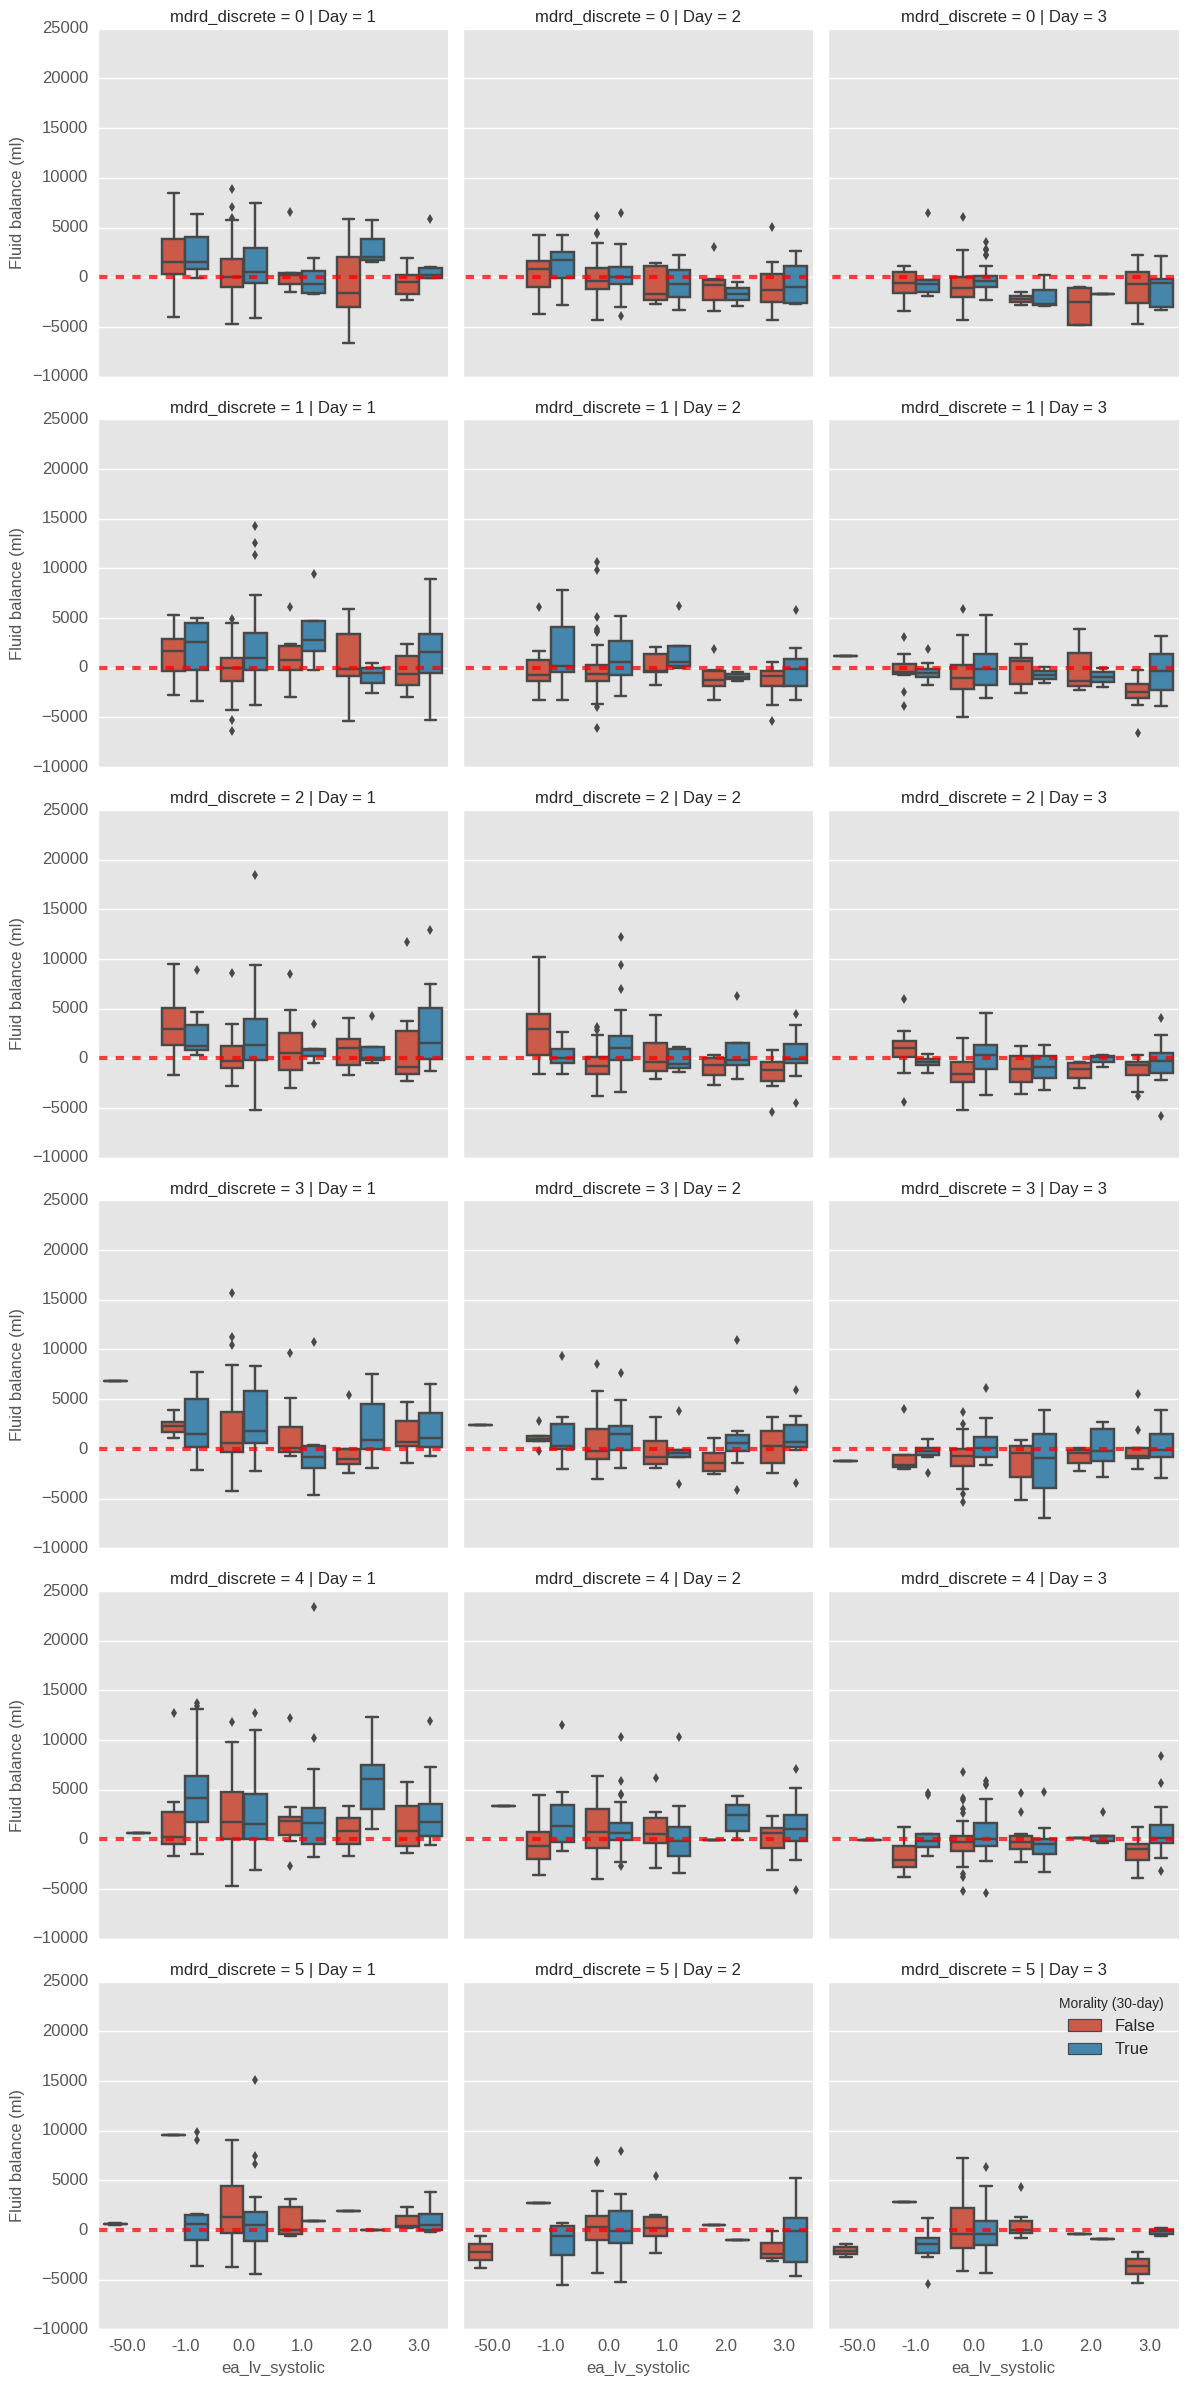

In [66]:
g  = sns.factorplot(data=to_plot, x='ea_lv_systolic', y='Fluid balance (ml)', kind='box', legend=False
               #, hue='Day', col='ex_congestive_heart_failure')
               , hue='day30_mortality', col='Day', row='mdrd_discrete')
for ax in g.axes.ravel():
    ax.plot([-100, 100], [0, 0], '--r', linewidth=3, alpha=0.75)
plt.legend(loc='best', title='Morality (30-day)')

In [67]:
filter = (ef.mdrd_discrete == 1) & (ef.ea_lv_systolic == 3) & (ef.fl_day1_balance_ml >= -7000)
group_0 = ef.loc[filter & (ef.day30_mortality == False)].fl_day1_balance_ml
group_0 = group_0.dropna()
group_1 = ef.loc[filter & (ef.day30_mortality == True)].fl_day1_balance_ml
group_1 = group_1.dropna()

-327.696277554 1908.39763337
1563.59588127 3470.94913103


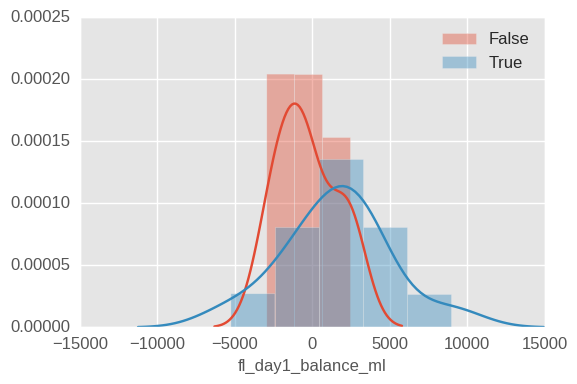

In [68]:
sns.distplot(group_0, label='False')
sns.distplot(group_1, label='True')
plt.legend()
print(group_0.mean(), group_0.std())
print(group_1.mean(), group_1.std())

In [69]:
ttest_ind(group_0, group_1, equal_var=False)

Ttest_indResult(statistic=-1.686357060496471, pvalue=0.1079343327535181)

In [70]:
data = ef.loc[filter,['fl_day1_balance_ml', 'day30_mortality']].dropna()
pearsonr(data.fl_day1_balance_ml, data.day30_mortality)

(0.3245789469661976, 0.12175208396933176)

## Classification of 30-day mortality using LV systolic, congestive heart failure, fluid balance, and MDRD

In [71]:
## form the feature and target vectors
def make_features(data):
    mdrd = data.mdrd
    age = data.age_at_intime/np.timedelta64('1', 'Y')
    age.loc[age<0] = age.max()
    gender = data.gender == 'F'
    lv_sys = pd.get_dummies(data.ea_lv_systolic, dummy_na=True)
    features = lv_sys
    features['mdrd'] = mdrd
    features['age'] = age
    features['gender'] = gender
    features['congestive_heart_failure'] = ef.ex_congestive_heart_failure
    features['mech_vent'] = ef.mech_vent
    features['fluid1'] = ef.fl_day1_balance_ml
    features['fluid2'] = ef.fl_day2_balance_ml
    ## too many NaN in fluid3, remove
    #features['fluid3'] = ef.fl_day3_balance_ml 
    return features

In [72]:
x = make_features(ef)
y = ef.day30_mortality

In [73]:
x.head()

,-50.0,-1.0,0.0,1.0,2.0,3.0,nan,mdrd,age,gender,congestive_heart_failure,mech_vent,fluid1,fluid2
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,41.378665,35.312726,True,0,0,4740.000000,1354.000000
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,114.829574,28.333983,False,0,1,-1564.012497,-1546.220001
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,122.368229,68.902651,True,1,1,5742.809568,NaN
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,128.793511,82.609906,False,1,0,NaN,NaN
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,79.474706,88.886091,False,0,1,-248.250000,-465.499996


In [74]:
filter = ~np.isnan(x.fluid1.values) & ~np.isnan(x.fluid2.values)
x = x.iloc[filter]
y = y.iloc[filter]

In [75]:
## split into train and test
I = np.random.permutation(len(x))
n = int(0.1*len(x))
x_train = x.iloc[I[n:]]
y_train = y.iloc[I[n:]]
x_test = x.iloc[I[:n]]
y_test = y.iloc[I[:n]]

In [76]:
print(y_test.mean())
print(y_train.mean())
print(y.mean())

0.396226415094
0.413793103448
0.412041392286


In [77]:
from sklearn.ensemble import RandomForestClassifier

In [78]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [79]:
print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

0.972831765935
0.679245283019


In [80]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.69      0.84      0.76        64
       True       0.64      0.43      0.51        42

avg / total       0.67      0.68      0.66       106



In [81]:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['False', 'True'], index=['False', 'True'])
conf.index.name = 'Observed'
conf.columns.name = 'Predicted'
conf

Predicted,False,True
Observed,,
False,54,10
True,24,18


In [82]:
pd.DataFrame(pd.Series(model.feature_importances_, index=x.columns)).sort_values(0, ascending=False)

,0
fluid2,0.237201
fluid1,0.194891
mdrd,0.194258
age,0.194052
mech_vent,0.038268
gender,0.031760
congestive_heart_failure,0.025033
0.0,0.018093
-1.0,0.015738
NaN,0.014858


In [83]:
from sklearn.ensemble import GradientBoostingClassifier

In [84]:
model = GradientBoostingClassifier()
model.fit(x_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [85]:
print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

0.817136886102
0.641509433962


In [86]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.68      0.78      0.72        64
       True       0.56      0.43      0.49        42

avg / total       0.63      0.64      0.63       106



In [87]:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['False', 'True'], index=['False', 'True'])
conf.index.name = 'Observed'
conf.columns.name = 'Predicted'
conf

Predicted,False,True
Observed,,
False,50,14
True,24,18


In [88]:
pd.DataFrame(pd.Series(model.feature_importances_, index=x.columns)).sort_values(0, ascending=False)

,0
mdrd,0.232620
age,0.228156
fluid2,0.210545
fluid1,0.208901
mech_vent,0.032726
3.0,0.029801
1.0,0.013988
gender,0.009330
-1.0,0.008979
2.0,0.006297


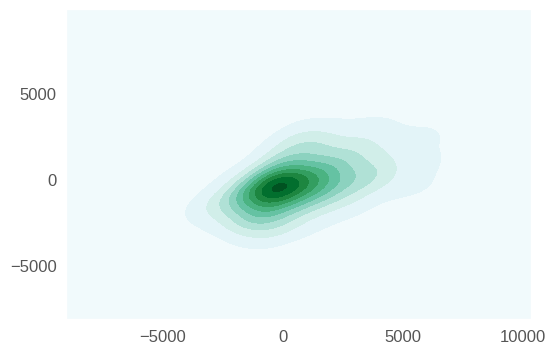

In [89]:
fluid1 = ef.fl_day1_balance_ml.values.copy()
fluid2 = ef.fl_day2_balance_ml.values.copy()
mask = np.isnan(fluid1) | np.isnan(fluid2)
mask |= (fluid1 < -7000) | (fluid2 < -7000) | (fluid1 > 8000) | (fluid2 > 8000)
fluid1 = fluid1[~mask]
fluid2 = fluid2[~mask]
sns.kdeplot(fluid1, fluid2, shade=True)

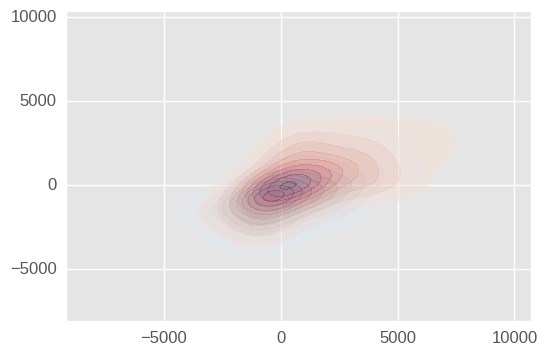

In [90]:
color = ['Blues', 'Reds']
i = 0
for name,group in ef.groupby('day30_mortality'):
    fluid1 = group.fl_day1_balance_ml.values.copy()
    fluid2 = group.fl_day2_balance_ml.values.copy()
    mask = np.isnan(fluid1) | np.isnan(fluid2)
    mask |= (fluid1 < -7000) | (fluid2 < -7000) | (fluid1 > 8000) | (fluid2 > 8000)
    fluid1 = fluid1[~mask]
    fluid2 = fluid2[~mask]
    sns.kdeplot(fluid1, fluid2, shade=True, label=str(name), cmap=color[i], lw=5, shade_lowest=False, alpha=0.33)
    i += 1